# Basic Optimization
In this notebook I'll optimize a trough model to fit the data. This is a necessary first-step to fitting trough models and finding model parameters, as it cuts down on the burn-in required when running the MCMC.

This particular will optimize the most basic 0-0 model, in which both the accumulation and lag models are as simple as possible. The accumulation is linear in the insolation $A(t) = aI(t)$, with the parameter $a$ having units of m$^3$/W, and the lag model being $l(t) = l_0$, or a constant lag with the paramter $l_0$ having units of mm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import mars_troughs as mt
import emcee, corner
%matplotlib inline

In [2]:
plt.rc("font", size=14, family="serif")
#plt.rc("text", usetex=True) #uncomment when we are ready to make final figures

In [3]:
#Create a trough object
test_acc_params = [1e-6] #parameter 'a', where we use Acc(t) = a * I(t)
acc_model_number = 0
test_lag_params = [1] #lag in mm
lag_model_number = 0
errorbar = 1. #errorbar in pixels on the datapoints
tr = mt.Trough(test_acc_params, test_lag_params,
                acc_model_number, lag_model_number,
                errorbar)

In [4]:
#Compare the trajectory with data
"""times = tr.ins_times
plt.plot(tr.get_xt(times), tr.get_yt(times))
xerr, yerr = tr.errorbar*tr.meters_per_pixel
print("Errorbars in meters: ", xerr, yerr)
print("meters per pixel = ", tr.meters_per_pixel)
plt.errorbar(x=tr.xdata, xerr=xerr, y=tr.ydata, yerr=yerr, c='k', marker='.', ls='')
xn,yn = tr.get_nearest_points()
plt.plot(xn, yn, ls='', marker='o', c='r')
plt.xlabel(r"Distance [m]")
plt.ylabel(r"Height [m]")
plt.xlim(xlim)
plt.ylim(ylim)"""

'times = tr.ins_times\nplt.plot(tr.get_xt(times), tr.get_yt(times))\nxerr, yerr = tr.errorbar*tr.meters_per_pixel\nprint("Errorbars in meters: ", xerr, yerr)\nprint("meters per pixel = ", tr.meters_per_pixel)\nplt.errorbar(x=tr.xdata, xerr=xerr, y=tr.ydata, yerr=yerr, c=\'k\', marker=\'.\', ls=\'\')\nxn,yn = tr.get_nearest_points()\nplt.plot(xn, yn, ls=\'\', marker=\'o\', c=\'r\')\nplt.xlabel(r"Distance [m]")\nplt.ylabel(r"Height [m]")\nplt.xlim(xlim)\nplt.ylim(ylim)'

In [5]:
#Define the log likelihood
def ln_likelihood(params):
    variance = params[0]
    if variance < 0: #prior on the variance (i.e. the error bars)
        return -1e99
    acc_params = np.array([params[1]])
    lag_params = np.array([params[2]])
    tr.set_model(acc_params, lag_params, np.sqrt(variance))
    if any(tr.lags_t < 0) or any(tr.lags_t > 20):
        return -1e99
    tr.compute_splines()
    return tr.lnlikelihood()

#And the negative of the log likelihood
def neg_ln_likelihood(params):
    return -ln_likelihood(params)

In [6]:
guess = [errorbar**2, test_acc_params[0], test_lag_params[0]]
result = op.minimize(neg_ln_likelihood, x0=guess, method='Nelder-Mead')
print(result)

 final_simplex: (array([[1.26579670e+00, 5.58717834e-07, 1.14157317e+00],
       [1.26579537e+00, 5.58720319e-07, 1.14159801e+00],
       [1.26578677e+00, 5.58718252e-07, 1.14159278e+00],
       [1.26578881e+00, 5.58721222e-07, 1.14159783e+00]]), array([174.27948677, 174.27952764, 174.27954855, 174.27957668]))
           fun: 174.27948676692182
       message: 'Optimization terminated successfully.'
          nfev: 107
           nit: 47
        status: 0
       success: True
             x: array([1.26579670e+00, 5.58717834e-07, 1.14157317e+00])


In [7]:
#Set the model to the best model
best = result['x']
variance = best[0]
acc_params = np.array([best[1]])
lag_params = np.array([best[2]])
tr.set_model(acc_params, lag_params, np.sqrt(variance))

Errorbars in meters:  562.5381540295874 22.501526161183495


(-505.53, 30)

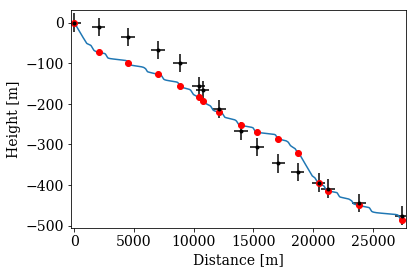

In [8]:
xlim = [np.min(tr.xdata)-300, np.max(tr.xdata)+300] #meters
ylim = [np.min(tr.ydata)-30, 30]

#Compare the trajectory with data
times = tr.ins_times
plt.plot(tr.get_xt(times), tr.get_yt(times))
xerr, yerr = tr.errorbar*tr.meters_per_pixel
print("Errorbars in meters: ", xerr, yerr)
plt.errorbar(x=tr.xdata, xerr=xerr, y=tr.ydata, yerr=yerr, c='k', marker='.', ls='')
xn,yn = tr.get_nearest_points()
plt.plot(xn, yn, ls='', marker='o', c='r')
plt.xlabel(r"Distance [m]")
plt.ylabel(r"Height [m]")
plt.xlim(xlim)
plt.ylim(ylim)

## Using MCMC

Now we can explore the likelihood using MCMC. This allows us to view the _posterior distributions_ of the parameters. In this way, we can see which are degenerate with each other, and why the model may not be working.

In [9]:
ndim = len(result.x)
nwalkers = ndim*4
nburn = 200
nsteps = 10000
p0 = [result.x + 1e-3*result.x*np.random.randn(ndim) for i in range(nwalkers)]

In [10]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood)
_ = sampler.run_mcmc(p0, nburn)

In [11]:
p0 = sampler.chain[:,-1]
sampler.reset()
_ = sampler.run_mcmc(p0, nsteps)

In [12]:
chain = sampler.flatchain

(120000, 3)


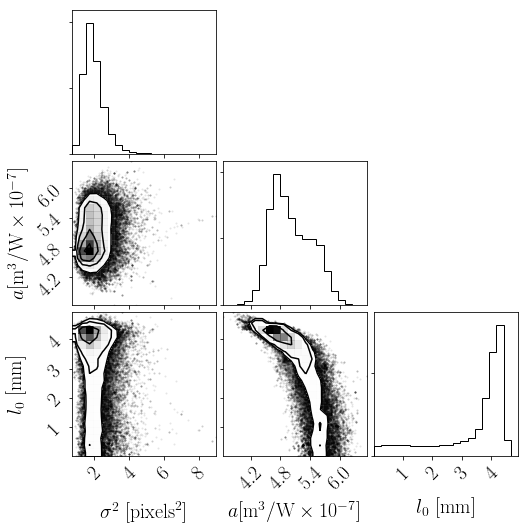

In [23]:
plt.rc("font", size=20, family="serif")
plt.rc("text", usetex=True)
#Make this figure better
s2 = chain[:,0]
a = chain[:,1]
l0 = chain[:,2]
print(chain.shape)
c_in = np.array([s2, a*1e7, l0]).T
fig = corner.corner(c_in, labels=[r"$\sigma^2\ [{\rm pixels}^2]$", 
                                  r"$a [{\rm m}^3/{\rm W}\times10^{-7}]$", r"$l_0\ [{\rm mm}]$"])
fig.savefig("corner_model00.png", dpi=300, bbox_inches="tight")

Errorbars in meters:  602.0841768147367 24.083367072589468


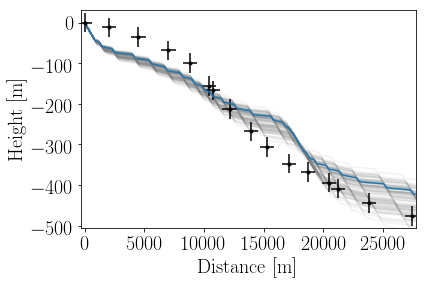

In [24]:
#Set the model to the best model
#Also make this figure better
best = chain[np.argmax(sampler.flatlnprobability)]
variance = best[0]
acc_params = np.array([best[1]])
lag_params = np.array([best[2]])
tr.set_model(acc_params, lag_params, np.sqrt(variance))
#Compare the trajectory with data
times = tr.ins_times
plt.plot(tr.get_xt(times), tr.get_yt(times))
xerr, yerr = tr.errorbar*tr.meters_per_pixel
print("Errorbars in meters: ", xerr, yerr)
plt.errorbar(x=tr.xdata, xerr=xerr, y=tr.ydata, yerr=yerr, c='k', marker='.', ls='')
xn,yn = tr.get_nearest_points()
#plt.plot(xn, yn, ls='', marker='o', c='r')
#Loop over random points in the chain and plot those too
for i in range(100):
    model = chain[np.random.randint(0, len(chain))]
    acc_params = np.array([model[1]])
    lag_params = np.array([model[2]])
    tr.set_model(acc_params, lag_params, np.sqrt(variance))
    plt.plot(tr.get_xt(times), tr.get_yt(times), c="gray", alpha=0.1, zorder=-1)
plt.xlabel(r"Distance [m]")
plt.ylabel(r"Height [m]")
plt.xlim(xlim)
plt.ylim(ylim)
plt.yticks([0, -100, -200, -300, -400, -500])
plt.xticks([0, 5000, 10000, 15000, 20000, 25000])
plt.savefig("model00_with_draws.png", dpi=300, bbox_inches="tight")